# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64

from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance

In [3]:
%run "PnL Computation.ipynb".ipynb
%run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=get_trade_in_usdt(trade_history)

In [14]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_91380\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4619.63,1.00,-131.89,2434.69,2302.80
OMUSDT,526.32,3214.62,0.70,0.00,2688.30,2688.30
BTCUSDT,601.02,739.41,0.16,3.54,138.39,141.93
SOLUSDT,281.20,226.80,0.05,0.00,-54.41,-54.41
JASMYUSDT,387.46,176.54,0.04,0.00,-210.92,-210.92
ETHUSDT,250.75,134.90,0.03,0.00,-115.84,-115.84
TRXUSDT,76.87,111.78,0.02,-10.72,34.92,24.20
BBUSDT,60.18,14.53,0.00,-39.73,-45.65,-85.38
BNBUSDT,1.14,1.04,0.00,-10.61,-0.10,-10.71
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

474

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: d5904672ad13b66b104ec5b4a8a2147e07da5946)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: bfccc5c69e703a4dd3691502db2006d54dd8f47d)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-03-14    2010.574081
2025-03-15    2202.769914
2025-03-16    2210.019473
2025-03-17    2353.886859
2025-03-18    2487.667077
Name: Total, Length: 177, dtype: float64

In [43]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-03-14     28.953544
2025-03-15    192.195833
2025-03-16      7.249559
2025-03-17    143.867386
2025-03-18    133.780218
Name: Total, Length: 177, dtype: float64

In [44]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-219.04552626675996, -334.9272908594338)

In [45]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [46]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [47]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [48]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [49]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [50]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [51]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

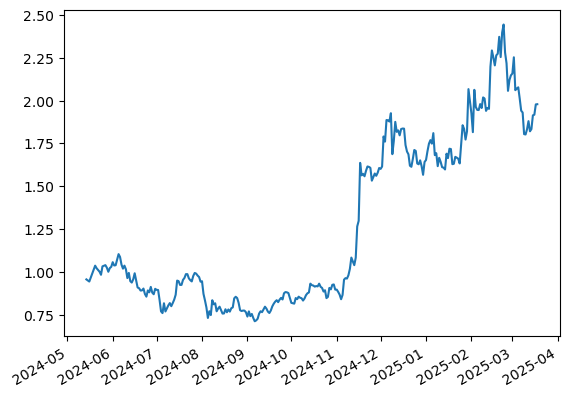

In [52]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

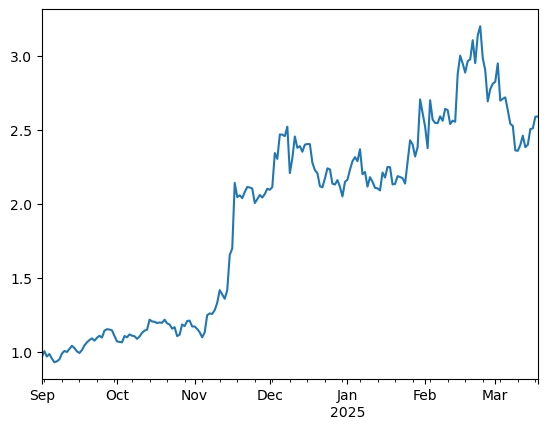

In [53]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [55]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [58]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [59]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [62]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.6394
OMUSDT,0.2282
AAVEUSDT,0.1325
PEPEUSDT,0.0000
BNBUSDT,0.0000
TRXUSDT,0.0000
SUIUSDT,0.0000
BTCUSDT,0.0000
XLMUSDT,0.0000
XRPUSDT,0.0000


In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.471341
BTCUSDT,0.300000
OMUSDT,0.228659


In [64]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

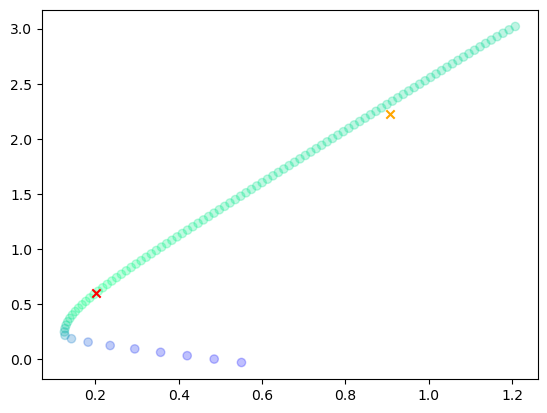

In [65]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [66]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [67]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3214.615623,0.695861,0.0639,0.631961
BTCUSDT,739.412748,0.160059,0.0000,0.160059
SOLUSDT,226.795427,0.049094,0.0000,0.049094
JASMYUSDT,176.542045,0.038216,0.0000,0.038216
ETHUSDT,134.902883,0.029202,0.0000,0.029202
TRXUSDT,111.784937,0.024198,0.0037,0.020498
BBUSDT,14.528242,0.003145,0.0000,0.003145
BNBUSDT,1.044193,0.000226,0.0606,-0.060374
PEPEUSDT,0.000002,0.000000,0.0054,-0.005400
PAXGUSDT,0.000000,0.000000,0.4013,-0.401300


### Current results

In [69]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [70]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.880187
OMUSDT,0.103701
TRXUSDT,0.016112


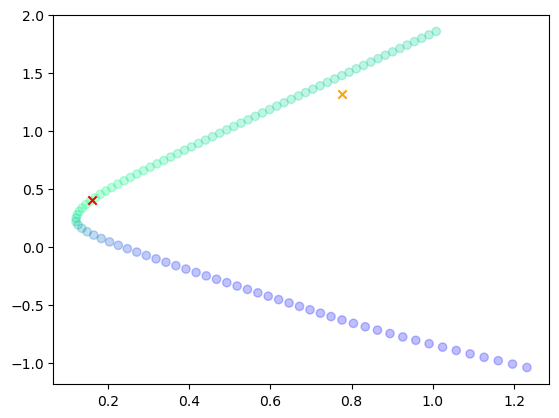

In [71]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [72]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3214.615623,0.695861,0.103701,0.592160
BTCUSDT,739.412748,0.160059,0.000000,0.160059
SOLUSDT,226.795427,0.049094,0.000000,0.049094
JASMYUSDT,176.542045,0.038216,0.000000,0.038216
ETHUSDT,134.902883,0.029202,0.000000,0.029202
TRXUSDT,111.784937,0.024198,0.016112,0.008086
BBUSDT,14.528242,0.003145,0.000000,0.003145
BNBUSDT,1.044193,0.000226,0.000000,0.000226
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.880187,-0.880187


# Risk Reward Analysis

In [74]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [75]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

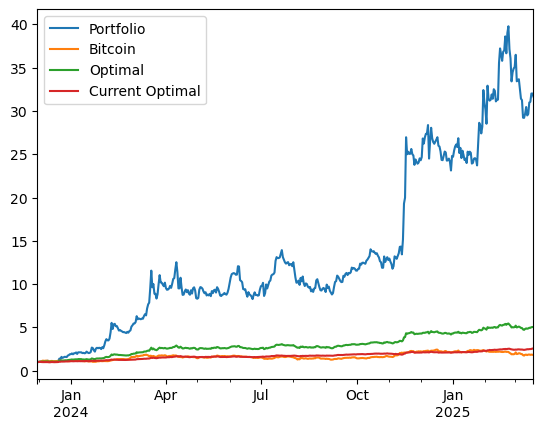

In [76]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [77]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

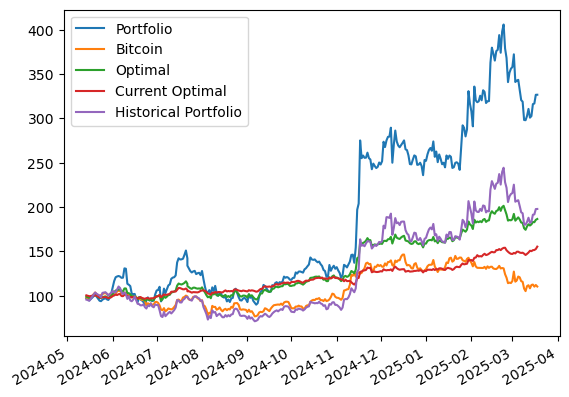

In [78]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [79]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-03-09,298.219995,108.074181,176.137279,147.393147,180.399004
2025-03-10,297.990552,105.172891,174.365008,145.948104,180.191407
2025-03-11,302.826009,110.822138,178.140106,147.234255,183.215484
2025-03-12,310.753904,111.816046,180.597470,148.695287,187.971314
2025-03-13,300.860853,108.335893,179.189549,150.723873,182.047066
2025-03-14,302.639009,112.099402,180.479211,150.237578,183.335317
2025-03-15,316.098799,112.572571,183.226137,151.378828,191.350939
2025-03-16,316.824428,110.193184,182.885980,151.545021,191.748673
2025-03-17,326.683860,112.092354,185.592007,152.640804,197.754476
2025-03-18,326.711380,110.351014,186.541651,155.369563,197.858229


## Volatilities

In [81]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.351019
 dtype: float64,
 0.351378497584007)

In [82]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.776496
 dtype: float64,
 0.7764957300067734)

In [83]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.906466
Bitcoin            0.433286
Optimal            0.351378
Current Optimal    0.176094
dtype: float64

In [84]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4684534748269592

In [85]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-1.5003718389001082

In [86]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7006069061013682

## Risk Contribution

In [88]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.257042,0.300000,0.028102,0.236061,0.136849,0.099212
OMUSDT,18.332480,0.228659,0.936389,0.717351,0.617527,0.099825
PAXGUSDT,0.232510,0.471341,0.035509,0.046588,0.029878,0.016710


In [89]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.467264,0.103701,0.327030,0.480343,0.430406,0.049937
TRXUSDT,0.005344,0.016112,0.012289,0.019783,0.006284,0.013499
PAXGUSDT,0.273302,0.880187,0.660681,0.499874,0.458958,0.040916


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.154117,0.70,0.932435,0.894807,0.826601,0.068207
BTCUSDT,0.031080,0.16,0.046228,0.041773,0.007365,0.034408
SOLUSDT,-0.019186,0.05,0.007455,0.023946,0.002231,0.021715
JASMYUSDT,-0.025373,0.04,0.003539,0.024864,0.003200,0.021664
ETHUSDT,-0.013880,0.03,0.003900,0.009207,0.000497,0.008710
TRXUSDT,0.006633,0.02,0.006443,0.005403,0.000408,0.004995


# Value At Risk

## Historical

### Optimal Weights

In [94]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.0280707613020627, -0.03970300400377211)

### Current Weights

In [96]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.056155096606911384, -0.08214405943169349)

In [97]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [98]:
var=historical_var.iloc[row]
var

OMUSDT      -0.038343
BTCUSDT     -0.004736
SOLUSDT     -0.002286
JASMYUSDT   -0.005135
ETHUSDT     -0.002485
TRXUSDT     -0.001602
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.054587
Name: 2025-02-02 00:00:00, dtype: float64

In [99]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.065157
BTCUSDT     -0.005685
SOLUSDT     -0.003596
JASMYUSDT   -0.003653
ETHUSDT     -0.001746
TRXUSDT     -0.000686
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.080523
dtype: float64

## Parametric

### Optimal Weights

In [102]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.036408448126293756, -0.046665564119510575)

### Current Weights

In [104]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.08045741188099087, -0.10312415678905935)

## Multivariate

### Optimal Weights

In [107]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.032574860381073635, -0.0419553833917343)

### Current Weights

In [109]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0735273770087817, -0.0939966198528862)

In [110]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

OMUSDT      -0.065467
BTCUSDT     -0.003344
SOLUSDT     -0.002425
JASMYUSDT   -0.002673
ETHUSDT     -0.000840
TRXUSDT     -0.000347
Portfolio   -0.075098
dtype: float64

In [111]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

OMUSDT      -0.065963
BTCUSDT     -0.003028
SOLUSDT     -0.002674
JASMYUSDT   -0.003207
ETHUSDT     -0.000822
TRXUSDT     -0.000298
Portfolio   -0.075992
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [115]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03268159645069491, -0.042334421637588375)

### Current Weights

In [117]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07413659419707488, -0.09453618363914891)

In [118]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [121]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03203931920536976, -0.04215924417973483)

### Current Weights

In [123]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07670022875301244, -0.09774734751664113)

In [124]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [127]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06511330401084504, -0.09032603167847579)

### Current Weights

In [129]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1584791588159148, -0.223666194449055)

In [130]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [133]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [134]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.036999643230872785, -0.046459587855155415)

### Current Weights

In [136]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0830242927373168, -0.10400794587612294)

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [138]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.156051,-0.066017,-0.074187,-0.065467,-0.068325
BTCUSDT,-0.000755,-0.003502,-0.003032,-0.003344,-0.003304
SOLUSDT,-0.000035,-0.002162,-0.001988,-0.002425,-0.001809
JASMYUSDT,-0.000775,-0.002207,-0.001909,-0.002673,-0.001862
ETHUSDT,-0.000108,-0.000814,-0.000750,-0.000840,-0.000798
TRXUSDT,0.000368,-0.000422,-0.000379,-0.000347,-0.000344
Portfolio,-0.157356,-0.075123,-0.082245,-0.075098,-0.076441


In [139]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.157350,-0.067291,-0.075374,-0.065963,-0.069395
BTCUSDT,-0.001209,-0.003478,-0.002755,-0.003028,-0.003409
SOLUSDT,-0.000177,-0.002005,-0.001949,-0.002674,-0.001716
JASMYUSDT,-0.000745,-0.001983,-0.002014,-0.003207,-0.001677
ETHUSDT,-0.000114,-0.000723,-0.000723,-0.000822,-0.000906
TRXUSDT,0.000331,-0.000472,-0.000210,-0.000298,-0.000331
Portfolio,-0.159264,-0.075952,-0.083025,-0.075992,-0.077434


## VaR Violation

In [141]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.028817,-0.053621,-0.046090,-0.011787
2024-01-15,-0.028817,-0.053628,-0.045167,0.012398
2024-01-16,-0.028817,-0.053679,-0.043953,0.024588
2024-01-17,-0.028817,-0.055043,-0.046868,-0.019695
2024-01-18,-0.028817,-0.055933,-0.048219,-0.015481
...,...,...,...,...
2025-03-15,-0.038633,-0.046555,-0.046616,0.015220
2025-03-16,-0.038633,-0.043148,-0.044655,-0.001856
2025-03-17,-0.038633,-0.043108,-0.044824,0.014796
2025-03-18,-0.038633,-0.043040,-0.044093,0.005117


In [142]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.045379,-0.084160,-0.082670,-0.015006
2024-05-29,-0.045379,-0.082059,-0.081835,-0.007208
2024-05-30,-0.045379,-0.072331,-0.070458,0.025761
2024-05-31,-0.045379,-0.076553,-0.072521,0.049656
2024-06-01,-0.045379,-0.083514,-0.078428,0.067499
...,...,...,...,...
2025-03-15,-0.081193,-0.084282,-0.090219,0.044475
2025-03-16,-0.081193,-0.084114,-0.089479,0.002296
2025-03-17,-0.081193,-0.082356,-0.088813,0.031120
2025-03-18,-0.060656,-0.066379,-0.068618,0.000084


<Axes: >

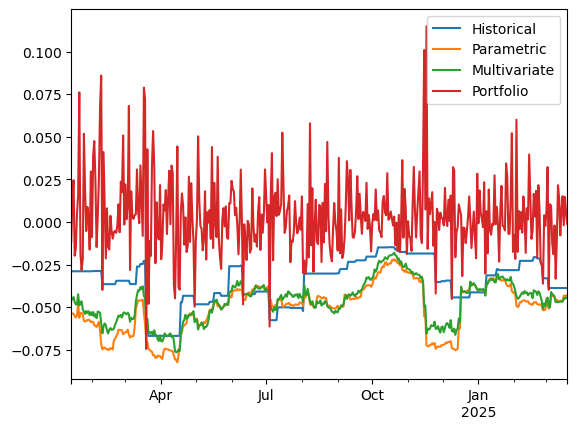

In [143]:
var_data.plot()

<Axes: >

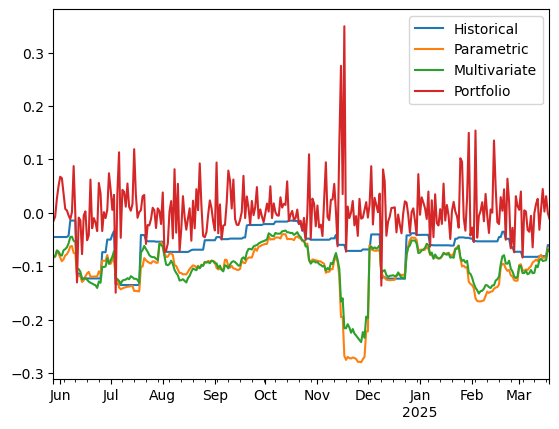

In [144]:
current_var_data.plot()

In [145]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032483,0.006961,0.006961
Kupiec Stat,3.161452,26.097409,26.097409
P-value,0.075396,0.0,0.0


In [146]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064189,0.010135,0.010135
Kupiec Stat,1.155894,14.51229,14.51229
P-value,0.282319,0.000139,0.000139


# Principal Component Analysis

## Historical PCA

In [149]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.80742883, 0.05792926, 0.05092163, 0.04778362, 0.03593666])

In [150]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.018063
ADAUSDT      0.019482
ALGOUSDT     0.020542
APTUSDT      0.018188
ARBUSDT      0.019827
ATOMUSDT     0.017943
AVAXUSDT     0.020035
BCHUSDT      0.015961
BNBUSDT      0.009375
BONKUSDT     0.024573
BTCUSDT      0.010141
CAKEUSDT     0.018797
DEXEUSDT     0.014013
DOGEUSDT     0.019269
DOTUSDT      0.018481
EOSUSDT      0.018757
ETCUSDT      0.016812
ETHUSDT      0.013843
FDUSDUSDT    0.000053
FETUSDT      0.023572
FILUSDT      0.020320
FLOWUSDT     0.019696
GRTUSDT      0.022127
HBARUSDT     0.019446
ICPUSDT      0.018319
IMXUSDT      0.020456
INJUSDT      0.021513
IOTAUSDT     0.021758
JASMYUSDT    0.021811
LDOUSDT      0.021174
LINKUSDT     0.018224
LTCUSDT      0.013666
MKRUSDT      0.013380
NEARUSDT     0.022108
NEXOUSDT     0.011861
OMUSDT       0.011268
OPUSDT       0.020388
PAXGUSDT     0.000279
PEPEUSDT     0.025068
QNTUSDT      0.015964
SANDUSDT     0.021946
SEIUSDT      0.021806
SHIBUSDT     0.018817
SOLUSDT      0.016889
STXUSDT      0.021478
SUIUSDT   

<Axes: >

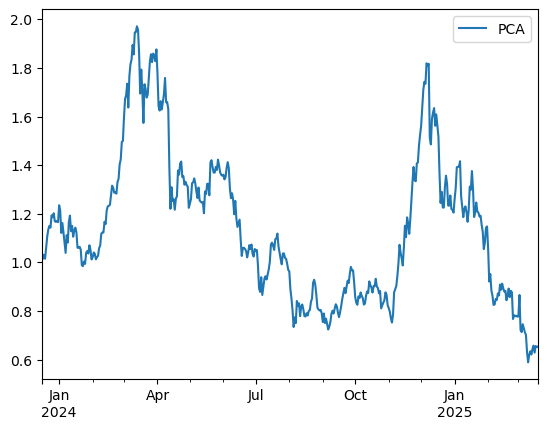

In [151]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

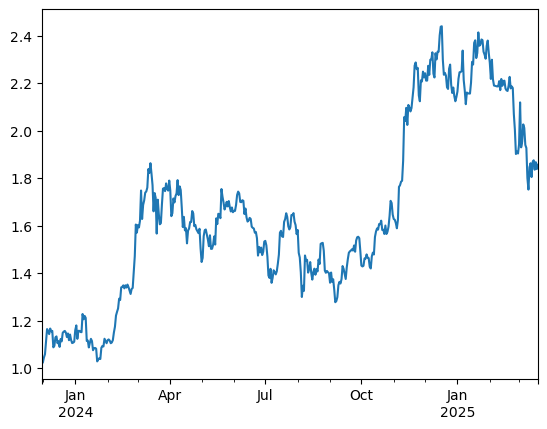

In [152]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [153]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.430611
WBETHUSDT    0.456100
ETHUSDT      0.456531
ATOMUSDT     0.475956
DOTUSDT      0.478358
ETCUSDT      0.487541
NEXOUSDT     0.508414
WBTCUSDT     0.545193
BTCUSDT      0.545248
AVAXUSDT     0.545985
EOSUSDT      0.547246
FILUSDT      0.566824
IOTAUSDT     0.569832
ARBUSDT      0.580529
XTZUSDT      0.584049
GRTUSDT      0.585457
LINKUSDT     0.610296
VETUSDT      0.613792
ALGOUSDT     0.623071
dtype: float64

<Axes: >

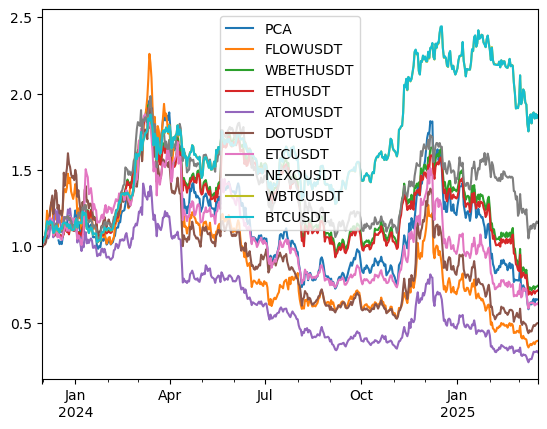

In [154]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

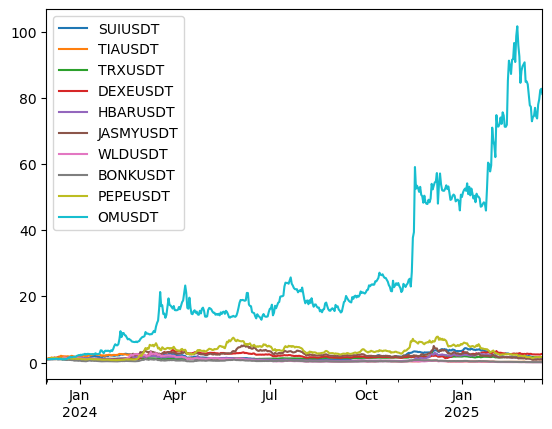

In [155]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [157]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59654626, 0.14094773, 0.10887263, 0.0884851 , 0.06514828])

In [158]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.088322
BTCUSDT      0.061159
SOLUSDT      0.108062
JASMYUSDT    0.172584
ETHUSDT      0.089061
TRXUSDT      0.051319
BBUSDT       0.197890
BNBUSDT      0.065808
PEPEUSDT     0.162873
PAXGUSDT     0.002922
Name: PC1, dtype: float64

<Axes: >

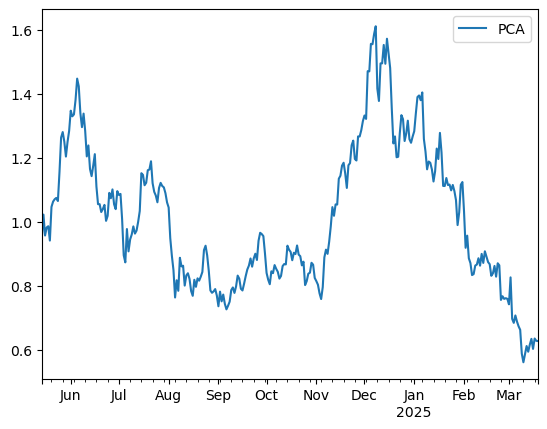

In [159]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

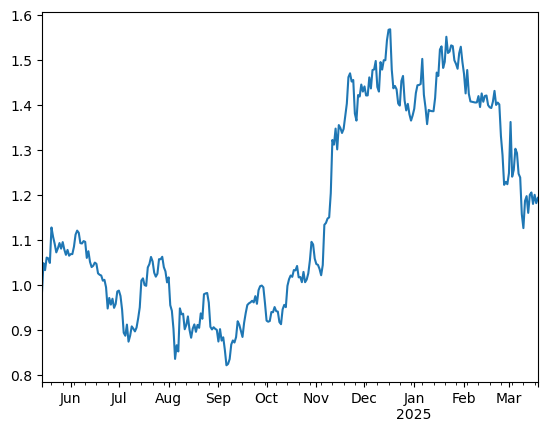

In [160]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [161]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.449747
BNBUSDT      0.506431
BTCUSDT      0.515253
SOLUSDT      0.527135
JASMYUSDT    0.707117
PEPEUSDT     0.760293
PAXGUSDT     0.781116
BBUSDT       0.807257
TRXUSDT      0.948398
dtype: float64

<Axes: >

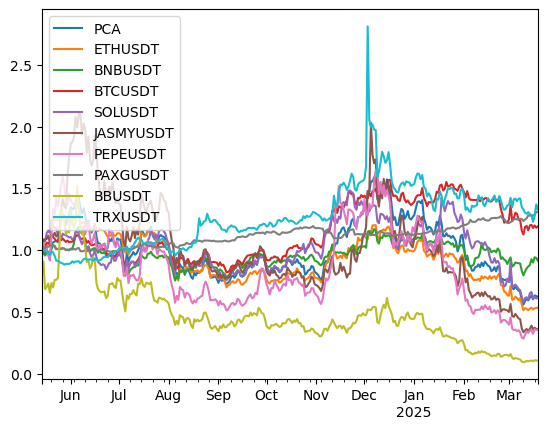

In [162]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [164]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.879085
BBUSDT       1.577525
JASMYUSDT    1.378883
SOLUSDT      1.240609
ETHUSDT      1.012076
BTCUSDT      1.000000
OMUSDT       0.874002
BNBUSDT      0.668942
TRXUSDT      0.338731
PAXGUSDT     0.037434
Name: BTCUSDT, dtype: float64

In [165]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT      1.845498
PEPEUSDT     1.624335
JASMYUSDT    1.585352
BBUSDT       1.370953
ETHUSDT      1.304519
BTCUSDT      1.000000
BNBUSDT      0.669743
OMUSDT       0.621120
TRXUSDT      0.403380
PAXGUSDT     0.027236
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [167]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [168]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BNBUSDT,0.260159
BBUSDT,0.199403
BTCUSDT,0.189983
ETHUSDT,0.158712
SOLUSDT,0.132053
JASMYUSDT,0.118513
TRXUSDT,0.104019
PEPEUSDT,0.036890
OMUSDT,-0.073583
PAXGUSDT,-0.202121


### Regression to PCA

In [170]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.0449783801223944

In [171]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.293531
BNBUSDT      1.153537
PCA          1.000000
ETHUSDT      0.996282
PAXGUSDT     0.753004
SOLUSDT      0.706010
JASMYUSDT    0.467365
PEPEUSDT     0.436354
BBUSDT       0.405788
TRXUSDT      0.283926
OMUSDT       0.249411
dtype: float64

In [172]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.385665
BTCUSDT      1.330199
PCA          1.000000
ETHUSDT      0.966685
TRXUSDT      0.952641
JASMYUSDT    0.773935
BBUSDT       0.679863
PEPEUSDT     0.653677
SOLUSDT      0.652295
OMUSDT       0.640483
PAXGUSDT    -0.000711
dtype: float64

### Correlation Matrix

<Axes: >

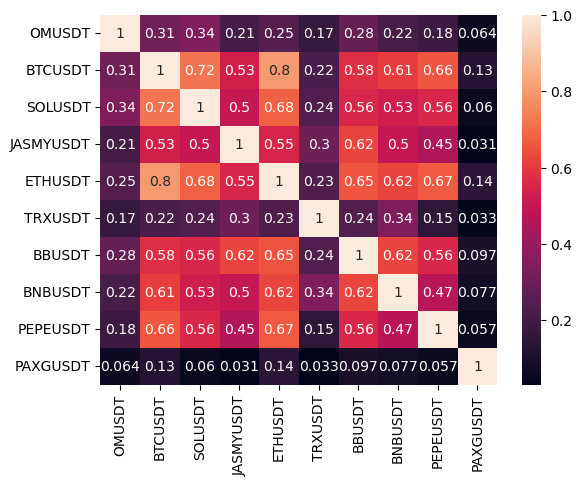

In [174]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

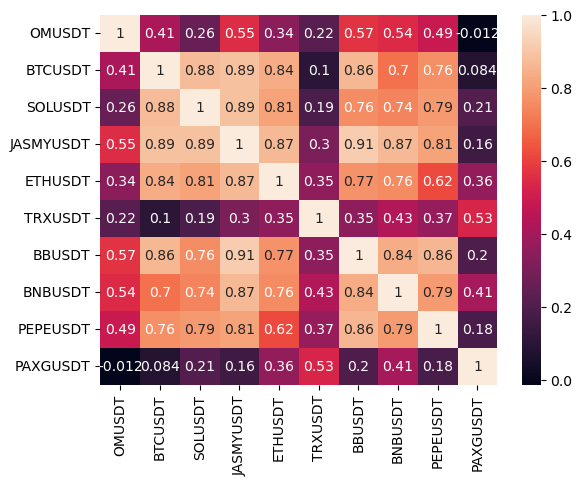

In [175]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [177]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.626168,0.000000,0.000000,0.150876,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.019283,0.260704,0.086231,0.000000,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.435186,0.000000,0.000000,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.176734,0.000000,0.000000,0.000000,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [178]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-08-11,0.134894,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.642936,0.0
2024-09-10,0.629842,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.153593,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-10-10,0.134894,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.148246,0.037696,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-11-09,0.134894,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2024-12-09,0.134894,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.030648,0.192622,0.0
2025-01-08,0.134894,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-02-07,0.134894,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-03-09,0.134894,0.0,0.0,0.0,0.0,0.0,0.0,0.154577,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2025-03-19,0.134892,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [179]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT    0.662316
OMUSDT      0.156383
AAVEUSDT    0.134892
SHIBUSDT    0.046409
SOLUSDT     0.000000
LTCUSDT     0.000000
Name: 2025-03-19 00:00:00, dtype: float64

In [180]:
git.create_or_replace_notebook("Prod.ipynb")

File 'Prod.ipynb' exists. Replacing the file...
✅ File 'Prod.ipynb' successfully pushed/updated to GitHub!
